### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
from sklearn.metrics import mean_squared_error

import pickle
import warnings
warnings.filterwarnings("ignore")

Noting from 02.Exploratory_Data_Analysis.ipynb, we saw that after covid started, there was a massive decline in the demand for taxis. This is why we decided to use precovid cases and covid cases to forecast different boroughs.

### Read in Dataset

In [2]:
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))

In [3]:
# Placeholder for RMSE scores;
placeholder = {}

### Let's separate before lockdown and after lockdown in Manhattan due to covid.

In [4]:
man_precovid_df = manhattan_df[:'2020-03-21']
man_covid_df = manhattan_df['2020-03-22':]

##### Splitting into train and test sets for Manhattan:

In [5]:
## PRECOVID TRAIN(70%), TEST SET(30%)
X = man_precovid_df.values
size = int(len(X) * 0.70)
man_precovid_train, man_precovid_test  = man_precovid_df[:size], man_precovid_df[size:]

## COVID  (70%), TEST (30%)
man_covid_train, man_covid_test = man_covid_df[:size], man_covid_df[size:]

# PRE-COVID: MANHATTAN

### Naive Forecast

Forecast the net day by taking last day value and estimate same value for the next day: Assuming next expected point is equal to the last observed point


In [6]:
man_precovid_train.index

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 01:00:00',
               '2019-06-01 02:00:00', '2019-06-01 03:00:00',
               '2019-06-01 04:00:00', '2019-06-01 05:00:00',
               '2019-06-01 06:00:00', '2019-06-01 07:00:00',
               '2019-06-01 08:00:00', '2019-06-01 09:00:00',
               ...
               '2019-12-24 02:00:00', '2019-12-24 03:00:00',
               '2019-12-24 04:00:00', '2019-12-24 05:00:00',
               '2019-12-24 06:00:00', '2019-12-24 07:00:00',
               '2019-12-24 08:00:00', '2019-12-24 09:00:00',
               '2019-12-24 10:00:00', '2019-12-24 11:00:00'],
              dtype='datetime64[ns]', name='pickup_time', length=4956, freq='H')

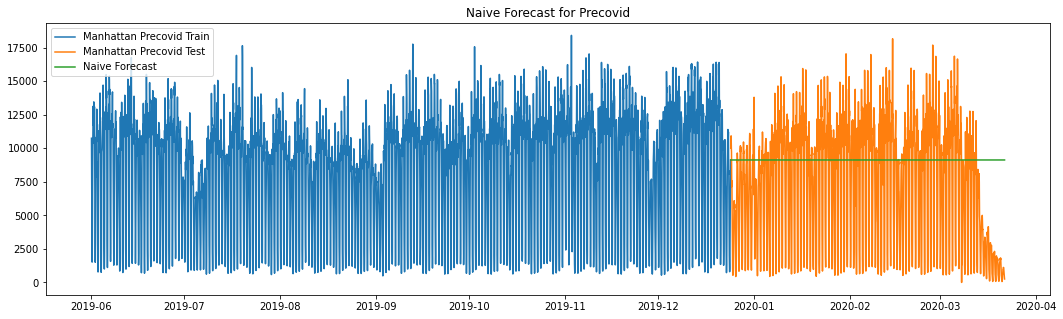

In [7]:
#dd= np.asarray(train_.count)
y_hat = man_precovid_test.copy()
y_hat['naive'] = man_precovid_train['count'][len(man_precovid_train['count'])-1]
plt.figure(figsize=(18,5))
plt.plot(man_precovid_train.index, man_precovid_train['count'], label='Train')
plt.plot(man_precovid_test.index,man_precovid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Manhattan Precovid Train', 'Manhattan Precovid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Precovid")
plt.show()

In [8]:
rmse_naive = math.sqrt(mean_squared_error(man_precovid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder['naive_forecast_baseline'] = rmse_naive
placeholder

rmse_naive: 4805.149712683199


{'naive_forecast_baseline': 4805.149712683199}

#### Baseline: Rolling Moving Average

Forecast the net day by taking last day value and estimate same value for the next day: Assuming next expected point is equal to the last observed point

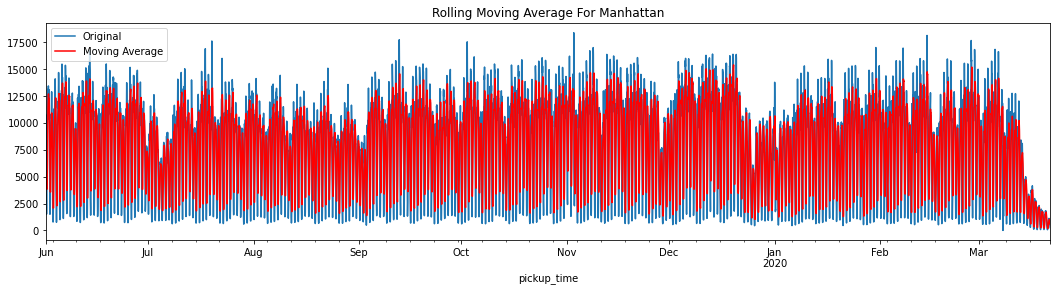

In [9]:
# Tail-rolling average transform
rolling = man_precovid_df.rolling(window=7)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (18,4))
# plot original and transformed dataset
man_precovid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Manhattan')
plt.show()

We put the window = 7 for size of the moving window. 

In [10]:
series = man_precovid_df
# prepare situation
X = series.values
window = 7
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)



predicted=5174.857143, expected=3797.000000
predicted=4182.428571, expected=5953.000000
predicted=3837.000000, expected=8583.000000
predicted=4175.714286, expected=9996.000000
predicted=4986.714286, expected=11151.000000
predicted=6162.428571, expected=12313.000000
predicted=7705.000000, expected=13127.000000
predicted=9274.285714, expected=12864.000000
predicted=10569.571429, expected=12060.000000
predicted=11442.000000, expected=11668.000000
predicted=11882.714286, expected=13011.000000
predicted=12313.428571, expected=13453.000000
predicted=12642.285714, expected=12797.000000
predicted=12711.428571, expected=10388.000000
predicted=12320.142857, expected=10799.000000
predicted=12025.142857, expected=12534.000000
predicted=12092.857143, expected=13090.000000
predicted=12296.000000, expected=11117.000000
predicted=12025.428571, expected=8981.000000
predicted=11386.571429, expected=6815.000000
predicted=10532.000000, expected=4868.000000
predicted=9743.428571, expected=2999.000000
predi

In [11]:
print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')


Test MSE: 17067390.709648937, RMSE:4131.2698664755535


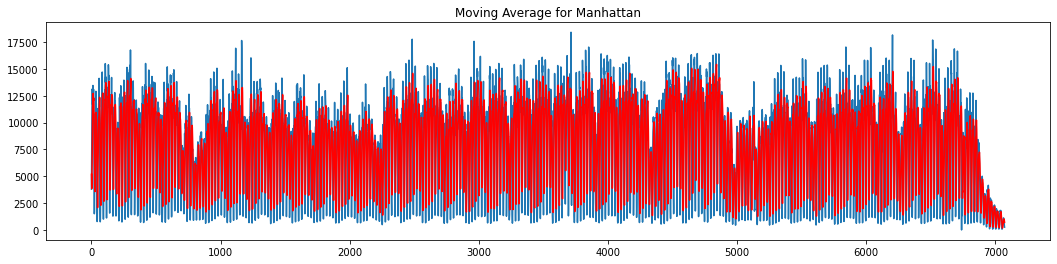

In [12]:
fig, ax =  plt.subplots(figsize=(18,4))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('Moving Average for Manhattan')
plt.show()

It's not very clear from the graph above so let's look at the zoomed graph of first 100 hours

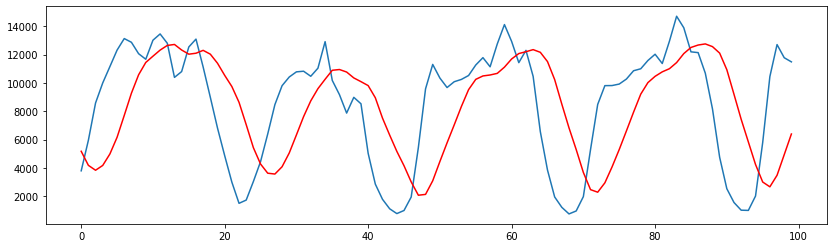

In [13]:
fig, ax =  plt.subplots(figsize=(14,4))
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red') #first 100th hour
plt.show()

Looking at the first 100 hour,  we can see there is some lag. 

I will instantiate the placeholder object to keep all the RMSE into one place

In [14]:
placeholder['moving_average_baseline'] = np.sqrt(mse_error)
placeholder

{'naive_forecast_baseline': 4805.149712683199,
 'moving_average_baseline': 4131.2698664755535}